# 🎯 A/B Тестирование: Основы и Практика

---

**Содержание:**
1. Что такое A/B тест и зачем он нужен?
2. Нулевая гипотеза H₀
3. Ошибки I и II рода — главные враги аналитика
4. t-test — основной инструмент
5. Проверка валидности критерия (AA-тесты)
6. Агрегация данных — почему нельзя использовать сырые логи
7. Bootstrap — универсальный инструмент

---

In [1]:
import numpy as np
import scipy.stats as stats
from tqdm import tqdm
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

---

# 1. 🔬 Что такое A/B тест?

## Как менялся Яндекс.Поиск со временем

<div style="display: flex;">
    <img src="pictures/Яндекс2000.jpg" width="250">
    <img src="pictures/Яндекс2007_2009.jpg" width="250">
    <img src="pictures/Яндекс2016_2017.jpg" width="250">
</div>

### Современная версия
<img src="pictures/Яндекс2025.png" width="500">

**В зрелых продуктах любое изменение — это тысячи проведённых экспериментов!**

## Практический кейс: Яндекс.Такси

**Тестируем новый функционал:** В высокий спрос пишем пользователю, что если подождать X минут — цена упадёт на Y рублей.

<img src="pictures/trips.png" width="500">

### Что могло произойти без A/B теста?
- 🌧️ Ухудшилась погода
- 🎄 Предновогодняя неделя
- ✅ Действительно крутую фичу предложили

**Без эксперимента мы не знаем, что именно повлияло на метрики!**

## Определение A/B тестирования

> **A/B-тестирование** — способ определить влияние изменений на продукт, **исключив внешние факторы**.

### Как это работает:
1. Разбиваем пользователей на **контрольную (A)** и **тестовую (B)** группы
2. Контрольная группа — без изменений
3. Тестовая группа — включаем новую фичу
4. Сравниваем результаты

### Ограничения:
- ⏱️ Требуется время на проведение
- 👥 Нужна большая клиентская база
- 🏗️ Требуется развитая инфраструктура


## Типы метрик в A/B тестах

<img src="pictures/metrics.png" width="700">

### Value метрики (абсолютные):
- **GMV** — общая стоимость поездок
- **Trips** — количество заказов
- **Supply Hours** — часы работы водителей

### Ratio метрики (отношения):
- **Acceptance Rate** = принятые офферы / показанные офферы
- **Completed Rate** = завершённые поездки / назначенные заказы
- **Конверсии** — пришёл → увидел → купил

---

# 2. 🎯 Нулевая гипотеза H₀

## Что такое гипотеза в статистике?

> **Статистическая гипотеза** — предположение о свойствах генеральной совокупности, которое можно проверить на основе выборочных данных.

### Два типа гипотез:

| Гипотеза | Обозначение | Описание |
|----------|-------------|----------|
| **Нулевая** | H₀ | Эффекта **нет**, различия случайны |
| **Альтернативная** | H₁ | Эффект **есть**, различия значимы |

### В контексте A/B теста:
- **H₀:** Средние в группах A и B равны (μₐ = μᵦ)
- **H₁:** Средние в группах A и B различаются (μₐ ≠ μᵦ)

## Логика проверки гипотез

### Принцип «от противного»:
1. **Предполагаем**, что H₀ верна (эффекта нет)
2. **Считаем p-value** — вероятность получить такие или более экстремальные данные при H₀
3. **Сравниваем** p-value с порогом α (обычно 0.05)

### Решение:
- Если **p-value < α** → Отвергаем H₀ → Эффект статистически значим
- Если **p-value ≥ α** → Не отвергаем H₀ → Эффект не обнаружен

### ⚠️ Важно:
> **Не отвергнуть H₀ ≠ Доказать H₀!**  
> Мы никогда не "принимаем" H₀, мы лишь не имеем достаточно доказательств для её отклонения.

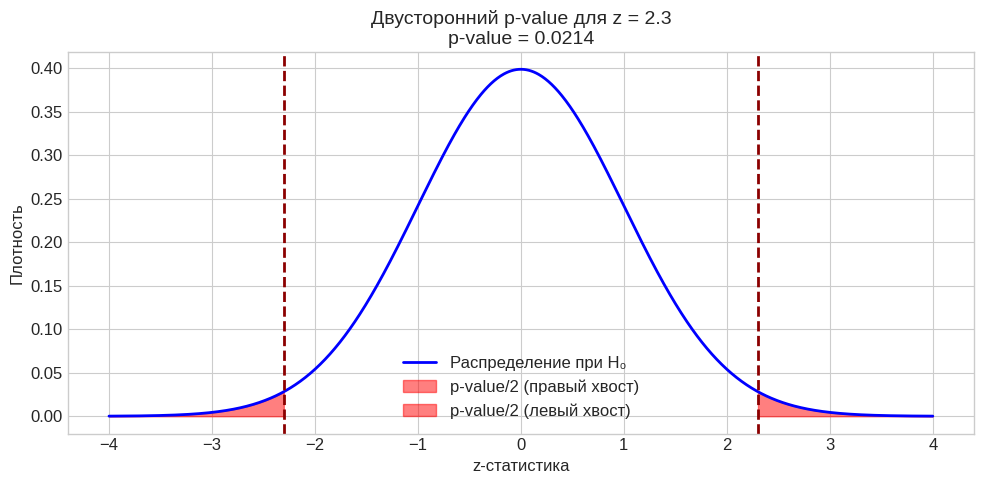

При z = 2.3: p-value = 0.0214
Вывод: p < 0.05, отвергаем H₀ на уровне значимости 5%


In [20]:
# Визуализация p-value
fig, ax = plt.subplots(figsize=(10, 5))

x = np.linspace(-4, 4, 1000)
y = stats.norm.pdf(x, 0, 1)

# Предположим, мы наблюдаем z-статистику = 2.3
observed_z = 2.3

ax.plot(x, y, 'b-', lw=2, label='Распределение при H₀')
ax.fill_between(x[x >= observed_z], 0, stats.norm.pdf(x[x >= observed_z], 0, 1), 
                color='red', alpha=0.5, label=f'p-value/2 (правый хвост)')
ax.fill_between(x[x <= -observed_z], 0, stats.norm.pdf(x[x <= -observed_z], 0, 1), 
                color='red', alpha=0.5, label=f'p-value/2 (левый хвост)')

ax.axvline(observed_z, color='darkred', linestyle='--', lw=2)
ax.axvline(-observed_z, color='darkred', linestyle='--', lw=2)

p_value = 2 * (1 - stats.norm.cdf(observed_z))
ax.set_xlabel('z-статистика', fontsize=12)
ax.set_ylabel('Плотность', fontsize=12)
ax.set_title(f'Двусторонний p-value для z = {observed_z:.1f}\np-value = {p_value:.4f}', fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()

print(f"При z = {observed_z:.1f}: p-value = {p_value:.4f}")
print(f"Вывод: p < 0.05, отвергаем H₀ на уровне значимости 5%")

---

# 3. ⚠️ Ошибки I и II рода

## Два типа ошибок в статистике

<img src="pictures/errors.png" width="600">

### Ошибка I рода (α) — False Positive
> Отклонили H₀, когда она верна  
> **"Нашли эффект, которого нет"**

### Ошибка II рода (β) — False Negative  
> Не отклонили H₀, когда верна H₁  
> **"Не нашли эффект, который есть"**

### Мощность теста
> **Мощность = 1 - β** — вероятность найти эффект, если он есть

## Связь между ошибками

<img src="pictures/errors2.png" width="700">

### Ключевые зависимости:
- α ↓ ⟹ β ↑ (строже порог → чаще пропускаем эффект)
- α ↑ ⟹ β ↓ (мягче порог → чаще ложные срабатывания)
- Эффект ↑ ⟹ β ↓ (большой эффект легче найти)

### Индустриальный стандарт:
- **α = 0.05** (5% ложных срабатываний)
- **β = 0.20** (80% мощность)

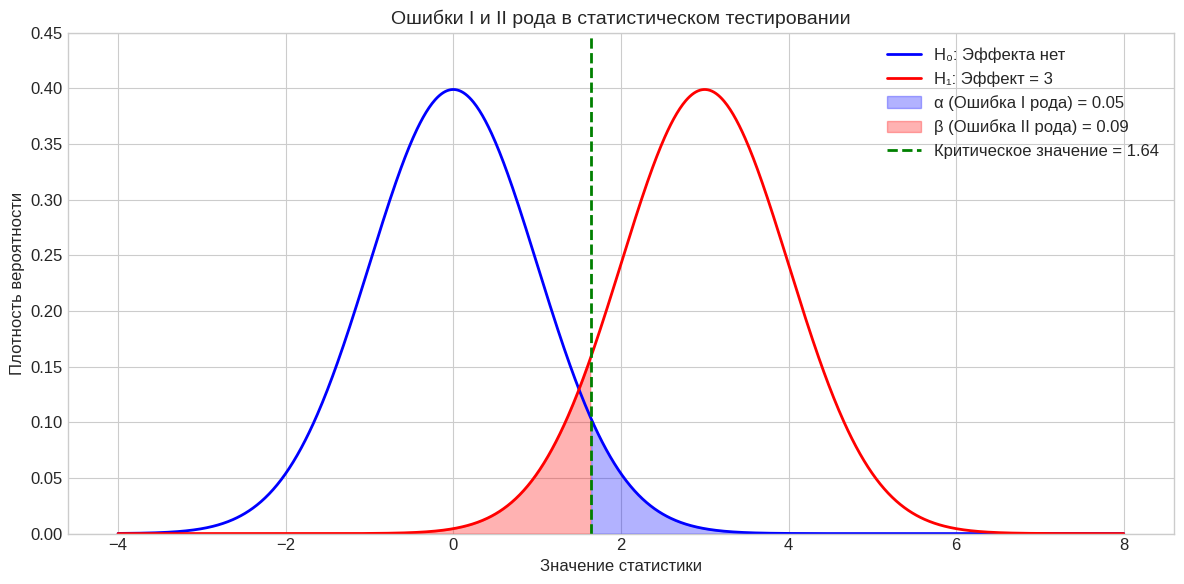

Мощность теста (1-β) = 0.91


In [2]:
# Визуализация ошибок I и II рода
fig, ax = plt.subplots(figsize=(12, 6))

x = np.linspace(-4, 8, 1000)

# H0: эффекта нет (среднее = 0)
y_h0 = stats.norm.pdf(x, 0, 1)

# H1: эффект есть (среднее = 3)
effect = 3
y_h1 = stats.norm.pdf(x, effect, 1)

# Критическое значение для α = 0.05 (односторонний)
alpha = 0.05
critical_value = stats.norm.ppf(1 - alpha)

ax.plot(x, y_h0, 'b-', lw=2, label='H₀: Эффекта нет')
ax.plot(x, y_h1, 'r-', lw=2, label=f'H₁: Эффект = {effect}')

# Закрашиваем область ошибки I рода (α)
x_alpha = x[x >= critical_value]
ax.fill_between(x_alpha, 0, stats.norm.pdf(x_alpha, 0, 1), 
                color='blue', alpha=0.3, label=f'α (Ошибка I рода) = {alpha}')

# Закрашиваем область ошибки II рода (β)
x_beta = x[x <= critical_value]
beta = stats.norm.cdf(critical_value, effect, 1)
ax.fill_between(x_beta, 0, stats.norm.pdf(x_beta, effect, 1), 
                color='red', alpha=0.3, label=f'β (Ошибка II рода) = {beta:.2f}')

ax.axvline(critical_value, color='green', linestyle='--', lw=2, 
           label=f'Критическое значение = {critical_value:.2f}')

ax.set_xlabel('Значение статистики', fontsize=12)
ax.set_ylabel('Плотность вероятности', fontsize=12)
ax.set_title('Ошибки I и II рода в статистическом тестировании', fontsize=14)
ax.legend(loc='upper right')
ax.set_ylim(0, 0.45)
plt.tight_layout()
plt.show()

print(f"Мощность теста (1-β) = {1-beta:.2f}")

---

# 4. 📊 t-test — основной инструмент

## Что такое t-test?

> **t-test (критерий Стьюдента)** — статистический тест для проверки гипотезы о равенстве средних в двух группах.

### Формула t-статистики:

$$t = \dfrac{\bar{X}_1 - \bar{X}_2}{\sqrt{\dfrac{s_1^2}{n_1} + \dfrac{s_2^2}{n_2}}}$$

Где:
- $\bar{X}_1, \bar{X}_2$ — средние в группах
- $s_1^2, s_2^2$ — выборочные дисперсии
- $n_1, n_2$ — размеры групп

## Виды t-test

### 1. Независимые выборки (Independent t-test)
- Две **разные** группы пользователей
- Используется в A/B тестах
- `scipy.stats.ttest_ind()`

### 2. Парный t-test (Paired t-test)
- **Те же** пользователи до и после
- Не подходит для классического A/B
- `scipy.stats.ttest_rel()`

### Предположения t-теста:
- ✅ **Независимость** наблюдений (обеспечиваем агрегацией)
- ⚠️ **Нормальность** — при больших выборках не критична (ЦПТ)
- ⚠️ **Равенство дисперсий** — используем Welch's t-test

In [21]:
# Демонстрация t-test
np.random.seed(42)

# Генерируем данные с эффектом 5%
n = 1000
control = np.random.exponential(500, n)
test = np.random.exponential(525, n)  # Эффект ~5%

# Применяем t-test (Welch's)
t_stat, p_value = stats.ttest_ind(test, control, equal_var=False)

print("=" * 50)
print("Результаты t-test (Welch's)")
print("=" * 50)
print(f"Контроль: среднее = {control.mean():.2f}, std = {control.std():.2f}")
print(f"Тест:     среднее = {test.mean():.2f}, std = {test.std():.2f}")
print(f"\nРазница: {test.mean() - control.mean():.2f} ({100*(test.mean()/control.mean()-1):.1f}%)")
print(f"t-статистика: {t_stat:.3f}")
print(f"p-value: {p_value:.6f}")
print(f"\nВывод: {'✅ Эффект значим (p < 0.05)' if p_value < 0.05 else '❌ Эффект не значим'}")

Результаты t-test (Welch's)
Контроль: среднее = 486.25, std = 486.01
Тест:     среднее = 543.43, std = 549.68

Разница: 57.18 (11.8%)
t-статистика: 2.463
p-value: 0.013854

Вывод: ✅ Эффект значим (p < 0.05)


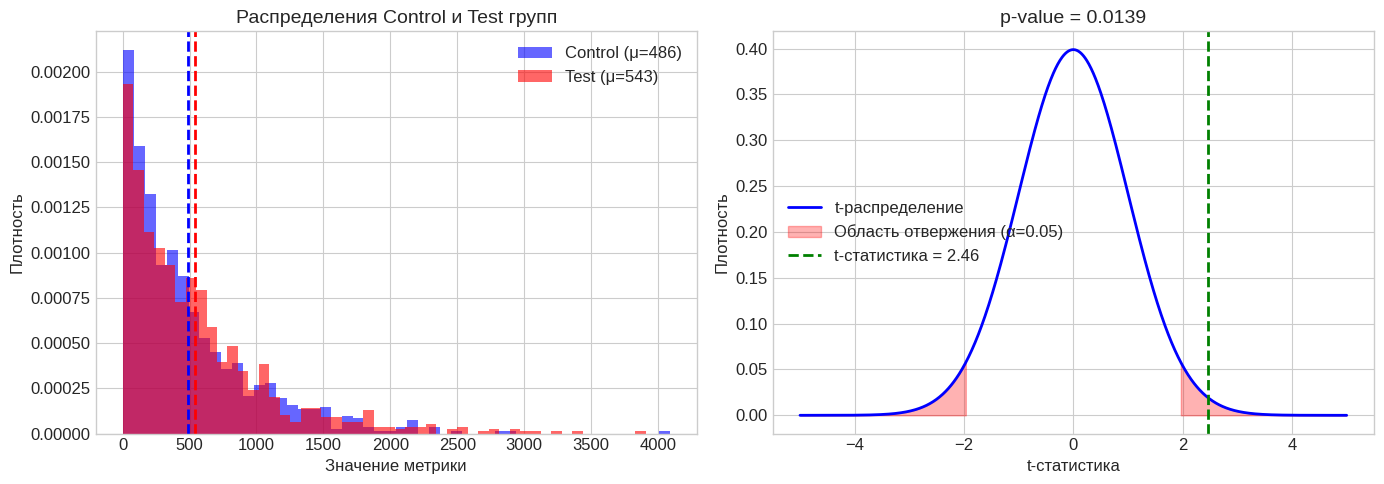

In [22]:
# Визуализация распределений и t-статистики
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Распределения групп
ax = axes[0]
ax.hist(control, bins=50, alpha=0.6, label=f'Control (μ={control.mean():.0f})', color='blue', density=True)
ax.hist(test, bins=50, alpha=0.6, label=f'Test (μ={test.mean():.0f})', color='red', density=True)
ax.axvline(control.mean(), color='blue', linestyle='--', lw=2)
ax.axvline(test.mean(), color='red', linestyle='--', lw=2)
ax.set_xlabel('Значение метрики', fontsize=12)
ax.set_ylabel('Плотность', fontsize=12)
ax.set_title('Распределения Control и Test групп', fontsize=14)
ax.legend()

# 2. t-распределение и наша статистика
ax = axes[1]
df = n + n - 2  # Степени свободы
x = np.linspace(-5, 5, 1000)
y = stats.t.pdf(x, df)

ax.plot(x, y, 'b-', lw=2, label='t-распределение')
ax.fill_between(x[x >= 1.96], 0, stats.t.pdf(x[x >= 1.96], df), color='red', alpha=0.3)
ax.fill_between(x[x <= -1.96], 0, stats.t.pdf(x[x <= -1.96], df), color='red', alpha=0.3, label='Область отвержения (α=0.05)')
ax.axvline(t_stat, color='green', linestyle='--', lw=2, label=f't-статистика = {t_stat:.2f}')
ax.set_xlabel('t-статистика', fontsize=12)
ax.set_ylabel('Плотность', fontsize=12)
ax.set_title(f'p-value = {p_value:.4f}', fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()

---

# 5. ✅ Проверка валидности критерия (AA-тесты)

## Что такое синтетический AA-тест?

> **AA-тест** — эксперимент без эффекта для проверки работоспособности критерия.

### Что проверяем:
- При H₀ (нет эффекта) p-value должно быть **равномерно распределено** на [0, 1]
- Ошибка I рода должна быть ≈ α (обычно 5%)

<img src="pictures/crit.png" width="500">

In [5]:
# Функция для проверки валидности критерия
def plot_pvalue_validation(pvalue_vector, title, color='skyblue'):
    """Визуализация валидности статистического критерия"""
    pvalue_vector = np.array(pvalue_vector)
    n = len(pvalue_vector)
    
    # Расчёт ошибки I рода и доверительного интервала
    alpha_hat = np.mean(pvalue_vector < 0.05)
    ci_width = 1.96 * np.sqrt(alpha_hat * (1 - alpha_hat) / n)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # 1. Гистограмма p-value
    axes[0].hist(pvalue_vector, bins=20, edgecolor='black', alpha=0.7, color=color, density=True)
    axes[0].axhline(1, color='red', linestyle='--', label='Равномерное')
    axes[0].set_xlabel('p-value')
    axes[0].set_ylabel('Плотность')
    axes[0].set_title(f'Гистограмма p-value\nОшибка I рода: {alpha_hat:.3f}')
    axes[0].legend()
    
    # 2. QQ-plot
    stats.probplot(pvalue_vector, dist=stats.uniform, plot=axes[1])
    axes[1].get_lines()[1].set_linestyle('--')
    axes[1].set_title('QQ-plot vs Uniform[0,1]')
    
    # 3. Эмпирическая функция распределения
    pvals_sorted = np.sort(pvalue_vector)
    ecdf = np.arange(1, n+1) / n
    axes[2].step(pvals_sorted, ecdf, where='post', label='Эмпирическая ФР', color=color)
    axes[2].plot([0, 1], [0, 1], 'r--', label='Теоретическая (Uniform)')
    axes[2].set_xlabel('p-value')
    axes[2].set_ylabel('F(p-value)')
    axes[2].set_title('Эмпирическая vs Теоретическая ФР')
    axes[2].legend()
    
    plt.suptitle(f'{title}', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Тест Колмогорова-Смирнова
    ks_stat, ks_pval = stats.kstest(pvalue_vector, 'uniform')
    print(f"Ошибка I рода: {alpha_hat:.4f} [{alpha_hat-ci_width:.4f}, {alpha_hat+ci_width:.4f}]")
    print(f"KS-тест: статистика = {ks_stat:.4f}, p-value = {ks_pval:.4f}")
    if ks_pval > 0.05:
        print("✅ Критерий валиден (p-value равномерно)")
    else:
        print("❌ Критерий НЕ валиден!")

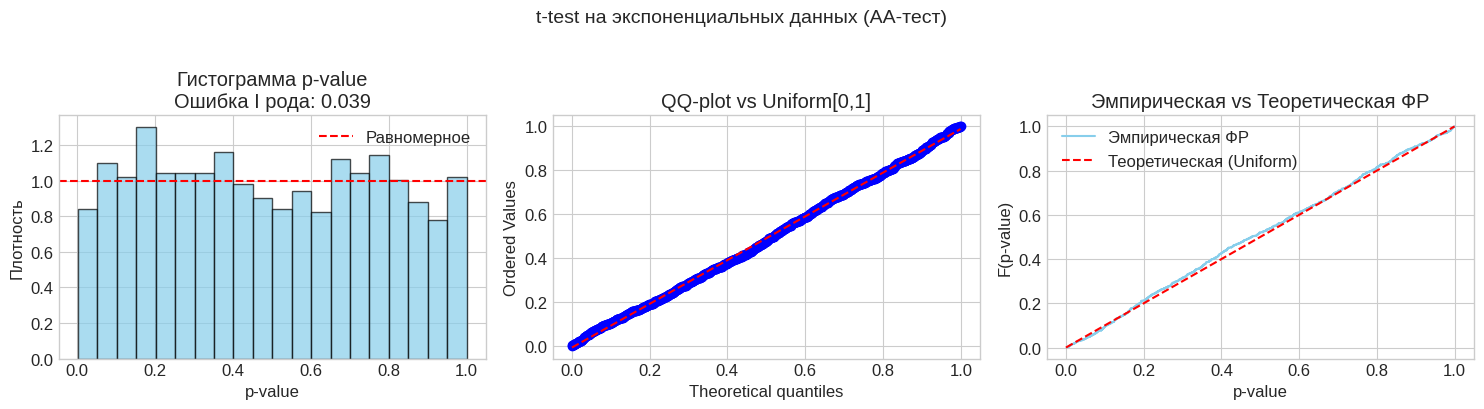

Ошибка I рода: 0.0390 [0.0270, 0.0510]
KS-тест: статистика = 0.0335, p-value = 0.2066
✅ Критерий валиден (p-value равномерно)


In [6]:
# Синтетический AA-тест для t-теста
np.random.seed(42)
pvalues_aa = []

for _ in range(1000):
    # Генерируем две группы без эффекта
    control = np.random.exponential(500, 1000)
    test = np.random.exponential(500, 1000)  # Тот же параметр!
    
    _, pval = stats.ttest_ind(test, control, equal_var=False)
    pvalues_aa.append(pval)

plot_pvalue_validation(pvalues_aa, 't-test на экспоненциальных данных (AA-тест)')

---

# 6. 📦 Агрегация данных

## Почему нельзя использовать сырые логи?

<img src="pictures/raw_logs.png" width="400">

### Проблема зависимости данных

Один пользователь генерирует **много событий** → события **зависимы** → критерий работает неправильно!

### Решение: Поюзерная агрегация

<img src="pictures/sum.png" width="300">

> **Один пользователь = одно наблюдение**

In [7]:
# Демонстрация проблемы зависимых данных
def generate_user_events(n_users=1000, mu_exp=500, mu_pois=3):
    """Генерация данных: пользователи с несколькими событиями"""
    noise_factors = [0.8, 0.9, 1, 1.1, 1.2]
    events = []  # Сырые события
    users = []   # Агрегированные по пользователям
    
    for _ in range(n_users):
        # Количество событий у пользователя (Пуассон)
        n_events = np.random.poisson(mu_pois)
        if n_events == 0:
            n_events = 1
        
        # Базовое значение для пользователя
        base_value = np.random.exponential(mu_exp)
        
        # События с шумом
        user_events = [base_value * random.choice(noise_factors) for _ in range(n_events)]
        events.extend(user_events)
        users.append(sum(user_events))
    
    return events, users

# Сравним критерий на сырых данных vs агрегированных
np.random.seed(42)
pvalues_raw = []
pvalues_agg = []

for _ in range(1000):
    test_events, test_users = generate_user_events()
    ctrl_events, ctrl_users = generate_user_events()
    
    _, pval_raw = stats.ttest_ind(test_events, ctrl_events, equal_var=False)
    _, pval_agg = stats.ttest_ind(test_users, ctrl_users, equal_var=False)
    
    pvalues_raw.append(pval_raw)
    pvalues_agg.append(pval_agg)

/tmp/ipykernel_798073/1998949566.py:37: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/home/batoshka/YSDA_ABweek/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


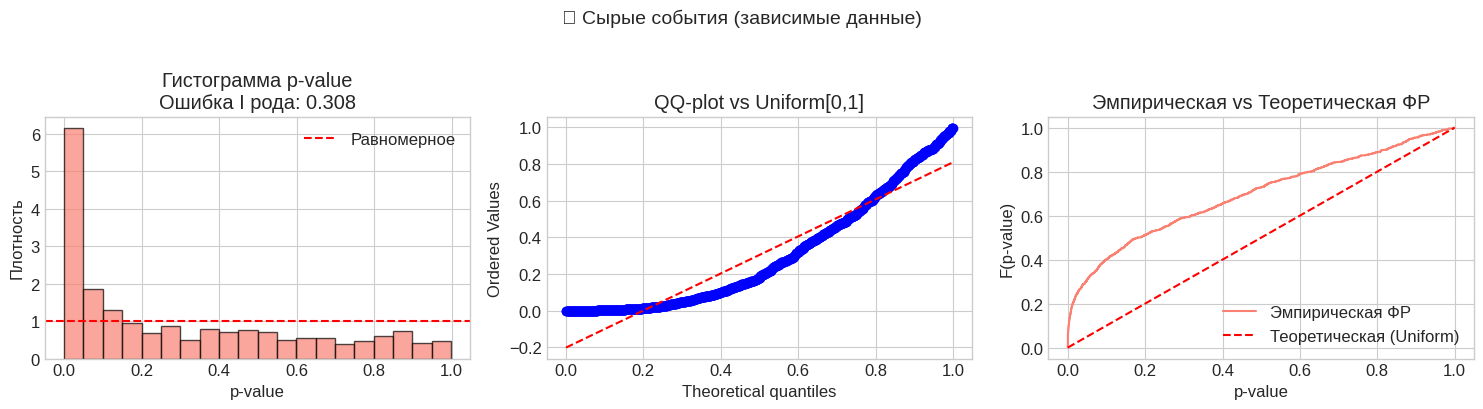

Ошибка I рода: 0.3080 [0.2794, 0.3366]
KS-тест: статистика = 0.3243, p-value = 0.0000
❌ Критерий НЕ валиден!


In [8]:
# Сырые данные — критерий НЕ работает!
plot_pvalue_validation(pvalues_raw, '❌ Сырые события (зависимые данные)', 'salmon')

/tmp/ipykernel_798073/1998949566.py:37: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/home/batoshka/YSDA_ABweek/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


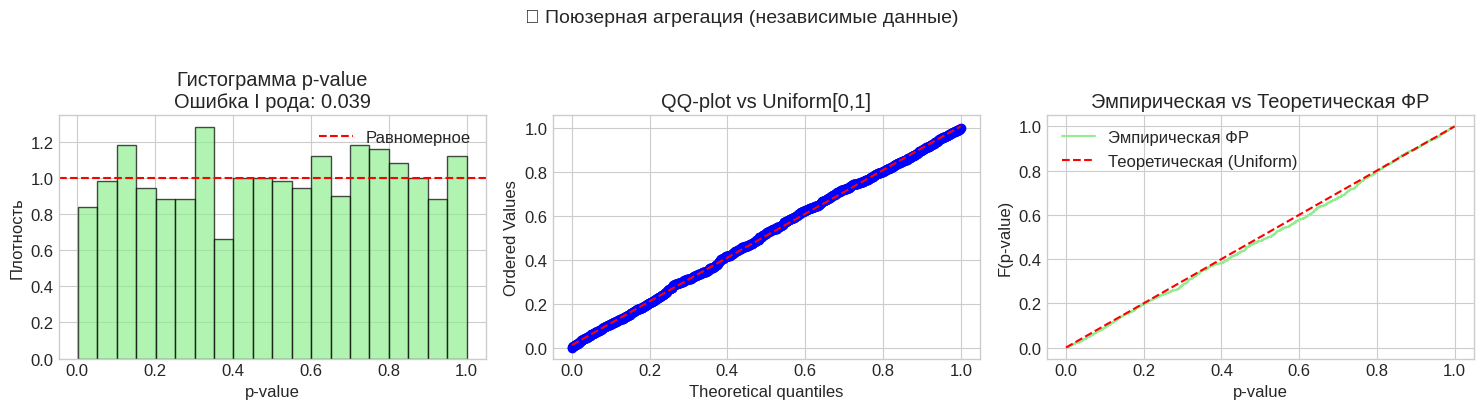

Ошибка I рода: 0.0390 [0.0270, 0.0510]
KS-тест: статистика = 0.0294, p-value = 0.3461
✅ Критерий валиден (p-value равномерно)


In [9]:
# Агрегированные данные — критерий работает
plot_pvalue_validation(pvalues_agg, '✅ Поюзерная агрегация (независимые данные)', 'lightgreen')

## Виды агрегации

<img src="pictures/agg.png" width="300">

### 1. Поюзерная агрегация
- Один пользователь = одно наблюдение
- ✅ Независимость данных
- ✅ Понятная интерпретация

### 2. Побакетная агрегация
- Группируем пользователей в "бакеты"
- ✅ Снижает влияние выбросов
- ❌ Меньше наблюдений → меньше мощность

---

# 7. 🎰 Bootstrap — универсальный инструмент

## Что такое Bootstrap?

> **Bootstrap** — метод оценки характеристик распределения через повторную выборку с возвращением.

### Алгоритм:
1. Из выборки размера n делаем B выборок размера n **с возвращением**
2. Для каждой считаем интересующую статистику
3. Получаем распределение статистики

### Преимущества:
- ✅ Не требует предположений о распределении
- ✅ Работает для любых статистик
- ✅ Автоматически учитывает зависимости

In [12]:
def bootstrap_test(test_data, control_data, n_bootstrap=1000, alpha=0.05):
    """
    Bootstrap-тест для сравнения средних.
    Возвращает p-value и доверительный интервал для разницы.
    """
    observed_diff = np.mean(test_data) - np.mean(control_data)
    
    # Bootstrap выборки
    bootstrap_diffs = []
    for _ in range(n_bootstrap):
        boot_test = np.random.choice(test_data, size=len(test_data), replace=True)
        boot_ctrl = np.random.choice(control_data, size=len(control_data), replace=True)
        bootstrap_diffs.append(np.mean(boot_test) - np.mean(boot_ctrl))
    
    bootstrap_diffs = np.array(bootstrap_diffs)
    
    # p-value (двусторонний)
    # Центрируем относительно 0 под H0
    centered_diffs = bootstrap_diffs - observed_diff
    p_value = 2 * min(
        np.mean(centered_diffs >= observed_diff),
        np.mean(centered_diffs <= observed_diff)
    )
    
    # Доверительный интервал
    ci_lower = np.percentile(bootstrap_diffs, 100 * alpha / 2)
    ci_upper = np.percentile(bootstrap_diffs, 100 * (1 - alpha / 2))
    
    return p_value, (ci_lower, ci_upper), bootstrap_diffs

# Пример использования
np.random.seed(42)
control = np.random.exponential(500, 1000)
test = np.random.exponential(520, 1000)  # Эффект 4%

pval, ci, boot_diffs = bootstrap_test(test, control, n_bootstrap=2000)

print(f"Наблюдаемая разница: {np.mean(test) - np.mean(control):.2f}")
print(f"Bootstrap p-value: {pval:.4f}")
print(f"95% ДИ: [{ci[0]:.2f}, {ci[1]:.2f}]")

Наблюдаемая разница: 52.01
Bootstrap p-value: 0.0240
95% ДИ: [4.58, 96.27]


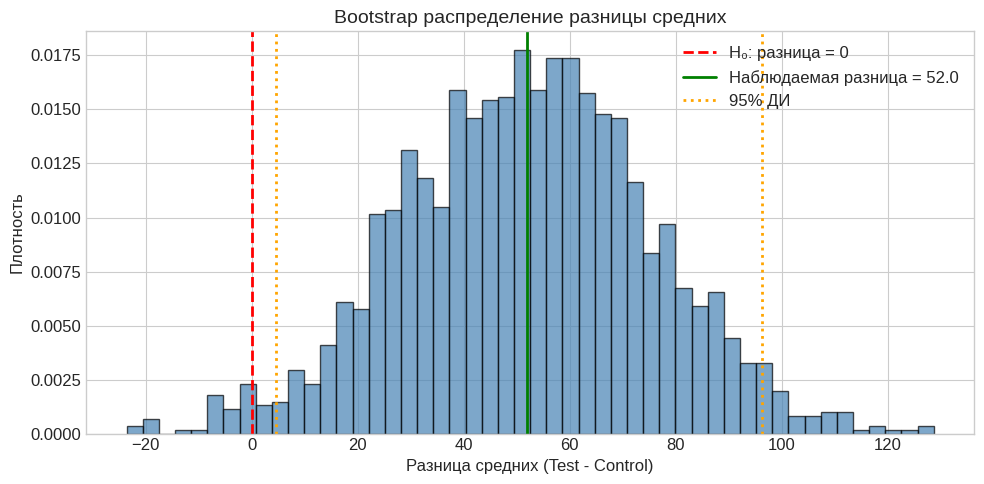

In [13]:
# Визуализация bootstrap распределения
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(boot_diffs, bins=50, edgecolor='black', alpha=0.7, color='steelblue', density=True)
ax.axvline(0, color='red', linestyle='--', lw=2, label='H₀: разница = 0')
ax.axvline(np.mean(test) - np.mean(control), color='green', linestyle='-', lw=2, 
           label=f'Наблюдаемая разница = {np.mean(test) - np.mean(control):.1f}')
ax.axvline(ci[0], color='orange', linestyle=':', lw=2)
ax.axvline(ci[1], color='orange', linestyle=':', lw=2, label=f'95% ДИ')

ax.set_xlabel('Разница средних (Test - Control)', fontsize=12)
ax.set_ylabel('Плотность', fontsize=12)
ax.set_title('Bootstrap распределение разницы средних', fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()

---

# 📚 Итоги: 9 ключевых тем A/B тестирования

| # | Тема | Главный вывод |
|---|------|---------------|
| 1 | **Введение в A/B** | A/B тест = рандомизированный контролируемый эксперимент |
| 2 | **Нулевая гипотеза H₀** | H₀: эффекта нет, p-value — вероятность данных при H₀ |
| 3 | **Ошибки I и II рода** | α = P(FP), β = P(FN), нужен баланс |
| 4 | **t-test** | Основной критерий сравнения средних |
| 5 | **AA-тесты** | Валидация: p-values ~ Uniform(0,1) |
| 6 | **Агрегация данных** | Агрегируем по пользователям, не по событиям |
| 7 | **Bootstrap** | Универсальный непараметрический метод |

---

## 🎯 Главные практические советы

1. **До эксперимента**: выберите главную метрику и размер выборки
2. **Рандомизация**: сплит по user_id, проверьте AA-тестом
3. **Метрики**: агрегируйте на уровне пользователей

<div style="text-align: center; padding: 50px;">
    <h2>Спасибо за внимание!</h2>
</div>